### Load and combine dataset

In [141]:
import numpy as np
import pandas as pd
from meta_path_utils import process_name_genre
import numpy as np
import pandas as pd
import networkx as nx
import random
from skipgram import train_skipgram  # from the provided skipgram.py
from meta_path_utils import build_hin, meta_path_walks_single

# ---------- Combine Train/Test ----------
R_train = np.load("data/ratings_train.npy")
R_test = np.load("data/ratings_test.npy")


R_combined = np.where(~np.isnan(R_train), R_train, R_test)
print(f"Combined dataset shape: {R_combined.shape} (users × items)")

df =pd.DataFrame(np.load("data/namesngenre.npy"), columns = ["raw_title","genre"])
df = process_name_genre(df)
G = build_hin(R_combined, df)
print("graph created")
R_combined[:5]
df["year"] = df["year"].astype(int)
print(df["year"].dtype)  # should show int64


Combined dataset shape: (610, 4980) (users × items)
graph created
int64


### Making sure the training for embeddings are relatively okay

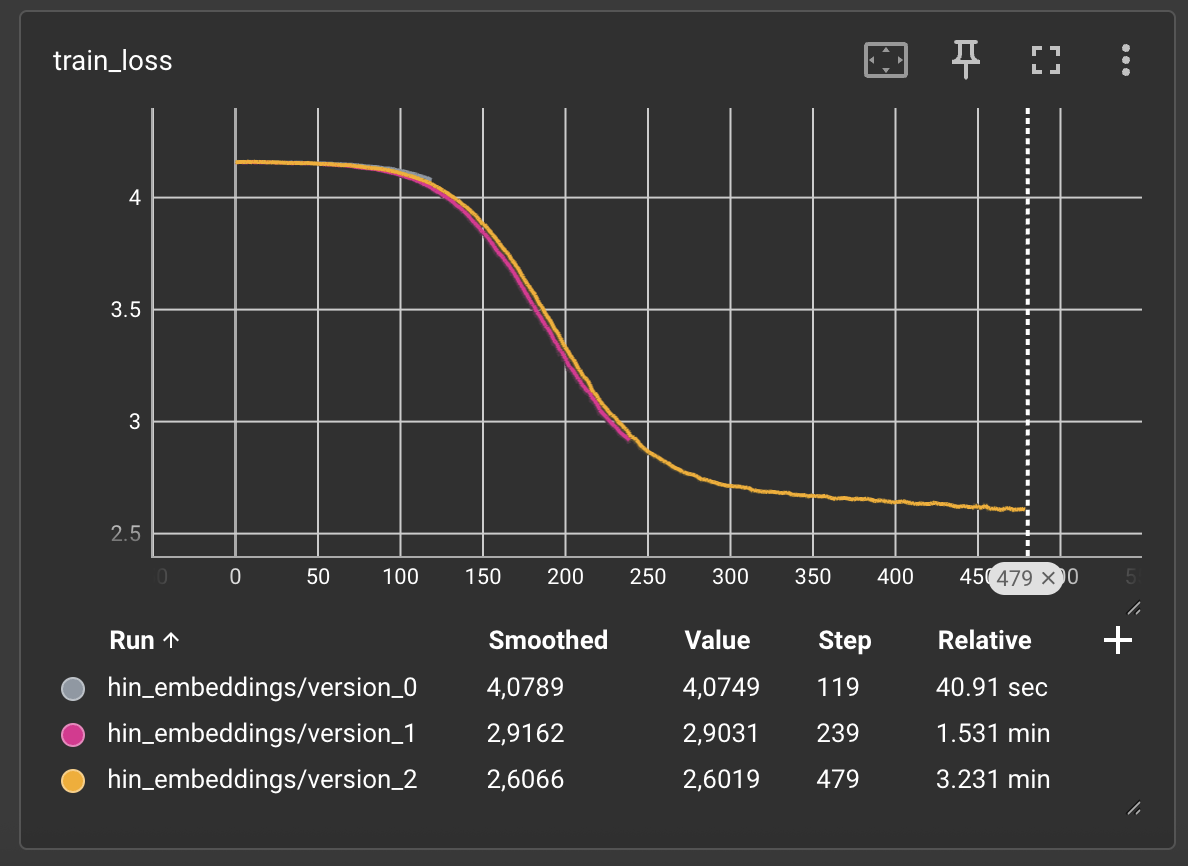

this is not super serious training but 

In [ ]:
# paths_UMU, model_UMU = meta_path_walks_single(
#     G,
#     meta_types=["user","movie","user"],
#     target_type="user",
#     d=64,   # embedding dimension
#     wl=40,  # walk length (counting only user nodes kept in the path)
#     ns=5,   # window size
#     r=10,    # walks per user
#     epochs = 20,
#     lr = 0.001
# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | center  | Embedding | 39.0 K | train
1 | context | Embedding | 39.0 K | train
----------------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 24/24 [00:10<00:00,  2.35it/s, v_num=2, train_loss=2.600]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:10<00:00,  2.35it/s, v_num=2, train_loss=2.600]


Metapaths choice,

first we try with UMU, MGM and MYM,

the paper uses we are going to also add UMYMU, UMGMU and MGMYM

In [29]:
# =====================================================
# Train and save embeddings for all selected meta-paths
# =====================================================

meta_paths_to_run = {
    # "UMU":   dict(meta_types=["user","movie","user"],   target_type="user"),
    # "MGM":   dict(meta_types=["movie","genre","movie"], target_type="movie"),
    # "MYM":   dict(meta_types=["movie","year","movie"],  target_type="movie"),
    "UMYMU": dict(meta_types=["user","movie","year","movie","user"], target_type="user"),
    "UMGMU": dict(meta_types=["user","movie","genre","movie","user"], target_type="user"),
    "MGMYM": dict(meta_types=["movie","genre","movie","year","movie"], target_type="movie"), ## that one is probably not very good 
}

# --- Common training hyperparameters ---
common_params = dict(
    d=64,   # embedding dimension
    wl=40,  # walk length
    ns=5,   # window size
    r=10,   # walks per node
    epochs=20,
    lr=0.001
)

import os, json, pickle, numpy as np
from datetime import datetime

# === Output directory ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_dir = f"hin_embeddings_runs/run_{timestamp}"
os.makedirs(base_dir, exist_ok=True)

def save_meta_path_outputs(name, paths, model):
    """Save paths and embeddings for one meta-path."""
    path_dir = os.path.join(base_dir, name)
    os.makedirs(path_dir, exist_ok=True)

    with open(os.path.join(path_dir, f"{name}_paths.json"), "w") as f:
        json.dump(paths, f)

    with open(os.path.join(path_dir, f"{name}_embeddings.pkl"), "wb") as f:
        pickle.dump(model, f)

    keys = sorted(model.keys(), key=lambda x: int(x[1:]))
    emb_mat = np.stack([model[k] for k in keys])
    np.save(os.path.join(path_dir, f"{name}_embeddings.npy"), emb_mat)
    with open(os.path.join(path_dir, f"{name}_nodes.json"), "w") as f:
        json.dump(keys, f)

    print(f" Saved {name} outputs to {path_dir}")

# === Train and store all meta-path embeddings ===
results = {}
for name, cfg in meta_paths_to_run.items():
    print(f"\n🚀 Training meta-path: {name} — {cfg['meta_types']}")
    paths, model = meta_path_walks_single(G, **cfg, **common_params)
    results[name] = (paths, model)
    save_meta_path_outputs(name, paths, model)

print(f"\nAll meta-path outputs saved under: {base_dir}")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | center  | Embedding | 39.0 K | train
1 | context | Embedding | 39.0 K | train
----------------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode



🚀 Training meta-path: UMYMU — ['user', 'movie', 'year', 'movie', 'user']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 24/24 [00:10<00:00,  2.35it/s, v_num=9, train_loss=2.630]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:10<00:00,  2.35it/s, v_num=9, train_loss=2.630]


/Users/barth/workspace/IASD/Data Science lab/assignment1-2025-circuit-virtuel/skipgram_light.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  torch.tensor(list(embeddings.values())),
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | center  | Embedding | 39.0 K | train
1 | context | Embedding | 39.0 K | train
----------------------------------------------
78.1 K    Trainable 

 Saved UMYMU outputs to hin_embeddings_runs/run_20251021_110033/UMYMU

🚀 Training meta-path: UMGMU — ['user', 'movie', 'genre', 'movie', 'user']
Epoch 19: 100%|██████████| 24/24 [00:10<00:00,  2.34it/s, v_num=10, train_loss=2.620]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:10<00:00,  2.34it/s, v_num=10, train_loss=2.620]
 Saved UMGMU outputs to hin_embeddings_runs/run_20251021_110033/UMGMU

🚀 Training meta-path: MGMYM — ['movie', 'genre', 'movie', 'year', 'movie']


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | center  | Embedding | 318 K  | train
1 | context | Embedding | 318 K  | train
----------------------------------------------
637 K     Trainable params
0         Non-trainable params
637 K     Total params
2.550     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 584/584 [00:18<00:00, 31.60it/s, v_num=11, train_loss=1.480]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 584/584 [00:18<00:00, 31.58it/s, v_num=11, train_loss=1.480]
 Saved MGMYM outputs to hin_embeddings_runs/run_20251021_110033/MGMYM

All meta-path outputs saved under: hin_embeddings_runs/run_20251021_110033


In [ ]:

# -------------------------------------------
# # 2) Run examples for UMU, MGM, and MYM
# # -------------------------------------------
# # You can pick any one meta-path at a time (single meta-path per Algorithm 1).
# # Example 1: UMU → target user embeddings
# paths_UMU, model_UMU = meta_path_walks_single(
#     G,
#     meta_types=["user","movie","user"],
#     target_type="user",
#     d=64,   # embedding dimension
#     wl=40,  # walk length (counting only user nodes kept in the path)
#     ns=5,   # window size
#     r=10,    # walks per user
#     epochs = 20,
#     lr = 0.001
# )

# # Example 2: MGM → target movie embeddings (genre-based)
# paths_MGM, model_MGM = meta_path_walks_single(
#     G,
#     meta_types=["movie","genre","movie"],
#     target_type="movie",
#     d=64,
#     wl=40,
#     ns=5,
#     r=10,
#     epochs = 20,
#     lr = 0.001
# )

# # # # Example 3: MYM → target movie embeddings (year-based)
# paths_MYM, model_MYM = meta_path_walks_single(
#     G,
#     meta_types=["movie","year","movie"],
#     target_type="movie",
#     d=64,
#     wl=40,
#     ns=5,
#     r=10,
#     epochs = 20,
#     lr = 0.001
# )




In [ ]:
# import os
# import json
# import numpy as np
# import pickle
# from datetime import datetime

# # === Create structured output directory ===
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# base_dir = f"hin_embeddings_runs/run_{timestamp}"
# os.makedirs(base_dir, exist_ok=True)

# def save_meta_path_outputs(name, paths, model):
#     """Save paths and learned embeddings for a given meta-path."""
#     path_dir = os.path.join(base_dir, name)
#     os.makedirs(path_dir, exist_ok=True)

#     # --- Save paths (walk sequences) as JSON ---
#     with open(os.path.join(path_dir, f"{name}_paths.json"), "w") as f:
#         json.dump(paths, f)

#     # --- Save embeddings (dict of node_id -> vector) ---
#     # both as pickle and numpy for convenience
#     with open(os.path.join(path_dir, f"{name}_embeddings.pkl"), "wb") as f:
#         pickle.dump(model, f)

#     # also a single .npy matrix and matching node order
#     keys = sorted(model.keys(), key=lambda x: int(x[1:]))
#     emb_mat = np.stack([model[k] for k in keys])
#     np.save(os.path.join(path_dir, f"{name}_embeddings.npy"), emb_mat)
#     with open(os.path.join(path_dir, f"{name}_nodes.json"), "w") as f:
#         json.dump(keys, f)

#     print(f"✅ Saved {name} outputs to {path_dir}")

# # === Save all three meta-paths ===
# save_meta_path_outputs("UMU", paths_UMU, model_UMU)
# save_meta_path_outputs("MGM", paths_MGM, model_MGM)
# save_meta_path_outputs("MYM", paths_MYM, model_MYM)

# print(f"\nAll meta-path outputs saved under: {base_dir}")



Total genres: 20


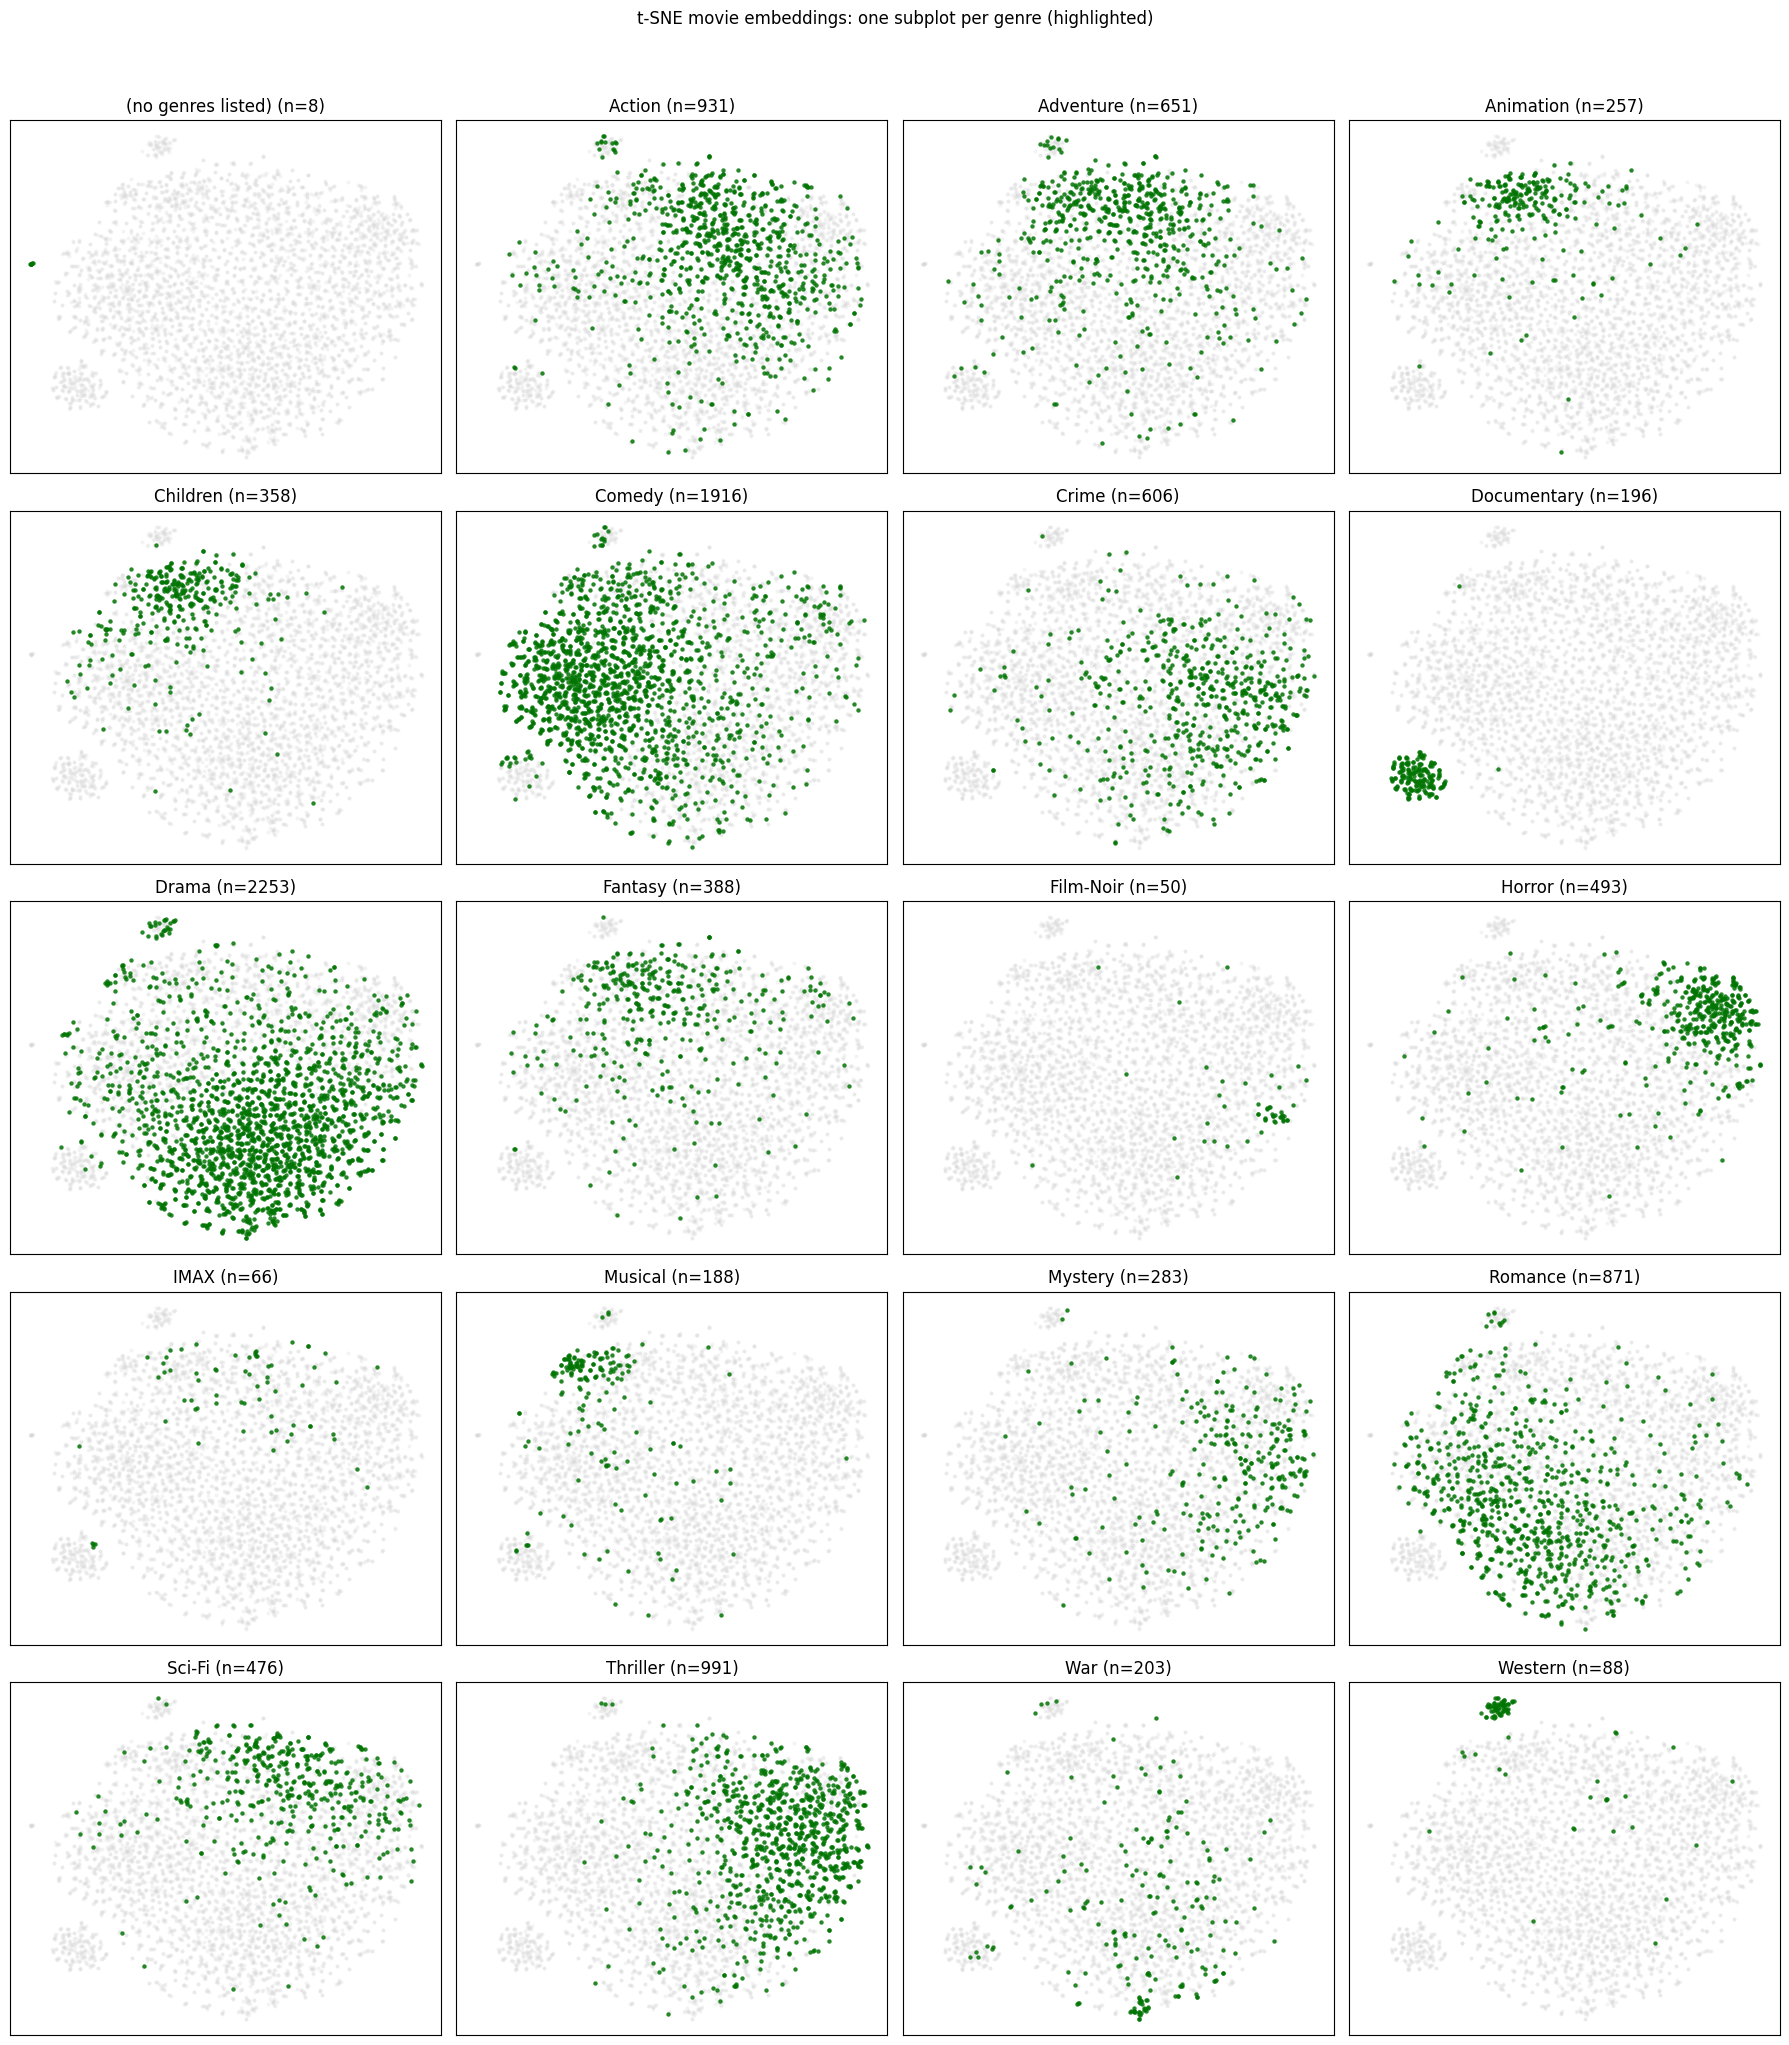

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.manifold import TSNE

# Ensure we have t-SNE–projected movie embeddings (X2d) and movie_nodes

# Extract movie embeddings
movie_nodes = [k for k in model_MGM if k.startswith("M")]  # type: ignore
X = np.stack([model_MGM[m] for m in movie_nodes])  # type: ignore

# Use t-SNE for nonlinear 2D projection
tsne = TSNE(
    n_components=2,
    perplexity=5,        # tune: 5–50 depending on dataset size
)
X2d = tsne.fit_transform(X)

# Unique genres from df
all_genres = sorted({g for lst in df["genres"] for g in lst})
print(f"Total genres: {len(all_genres)}")

n = len(all_genres)
cols = 4 if n >= 4 else max(1, n)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

# Pre-compute movie indices for faster masking
movie_indices = np.array([int(m[1:]) for m in movie_nodes], dtype=int)

for i, genre in enumerate(all_genres):
    ax = axes[i]
    # Mask movies that contain the current genre
    has_genre = np.array([genre in df.loc[idx, "genres"] for idx in movie_indices])
    # Background (all others) in light gray
    if np.any(~has_genre):
        ax.scatter(X2d[~has_genre, 0], X2d[~has_genre, 1], s=8, c="#d3d3d3", alpha=0.25, linewidths=0)
    # Highlight current genre
    if np.any(has_genre):
        ax.scatter(X2d[has_genre, 0], X2d[has_genre, 1], s=10, c="#017503", alpha=0.85, linewidths=0)
    ax.set_title(f"{genre} (n={int(has_genre.sum())})")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("t-SNE movie embeddings: one subplot per genre (highlighted)", y=1.02)
plt.tight_layout()
plt.show()


Total year: 101


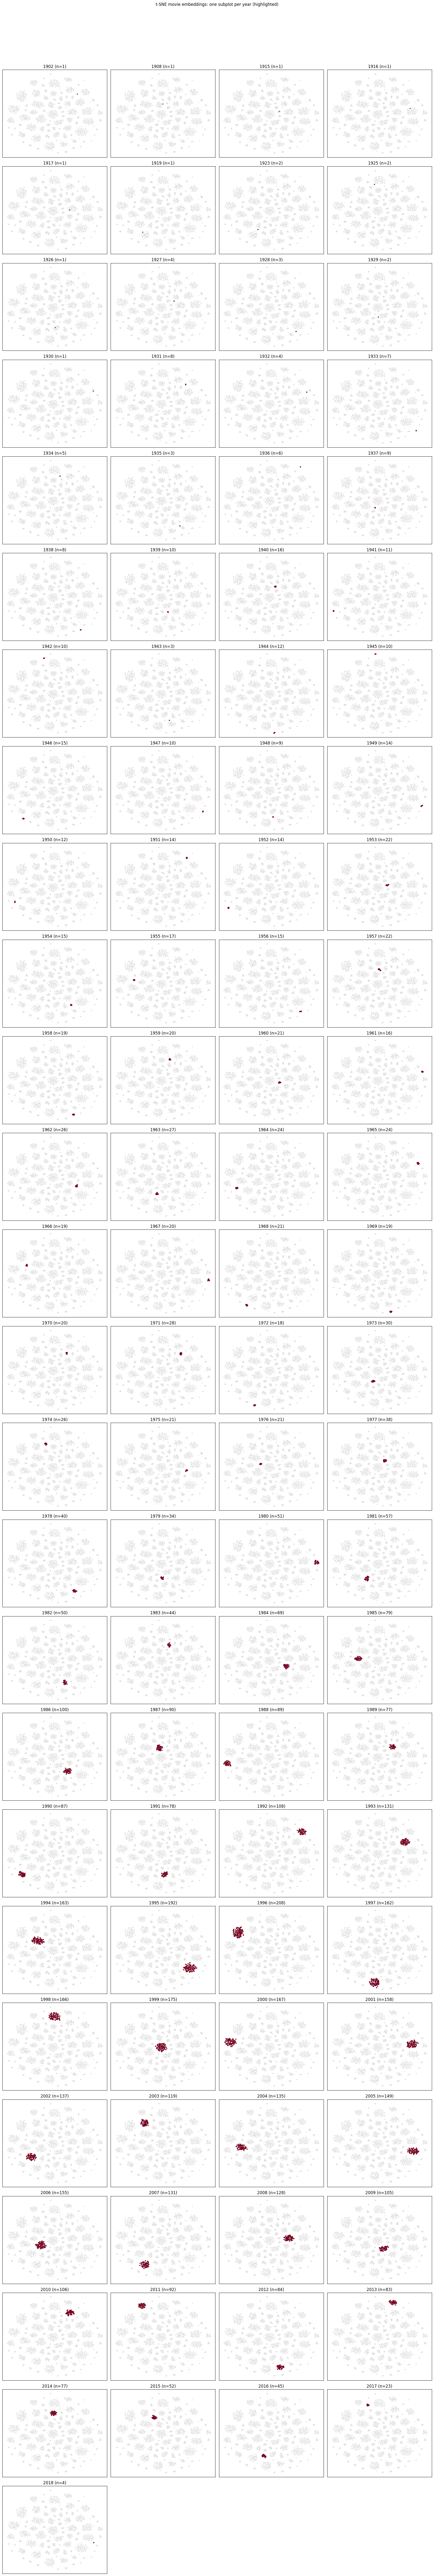

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.manifold import TSNE

# Ensure we have t-SNE–projected movie embeddings (X2d) and movie_nodes

# Extract movie embeddings
movie_nodes = [k for k in model_MYM if k.startswith("M")]  # type: ignore
X = np.stack([model_MYM[m] for m in movie_nodes])  # type: ignore

# Use t-SNE for nonlinear 2D projection
tsne = TSNE(
    n_components=2,
    perplexity=5,       
)
X2d = tsne.fit_transform(X)

# Unique genres from df
all_years =sorted({year for year in df["year"].unique()})
print(f"Total year: {len(all_years)}")

n = len(all_years)
cols = 4 if n >= 4 else max(1, n)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

# Pre-compute movie indices for faster masking
movie_indices = np.array([int(m[1:]) for m in movie_nodes], dtype=int)

for i, year in enumerate(all_years):
    ax = axes[i]
    # Mask movies that contain the current year
    has_year = np.array([df.loc[idx, "year"] == year for idx in movie_indices])
    # Background (all others) in light gray
    if np.any(~has_year):
        ax.scatter(X2d[~has_year, 0], X2d[~has_year, 1], s=8, c="#d3d3d3", alpha=0.25, linewidths=0)
    # Highlight current genre
    if np.any(has_year):
        ax.scatter(X2d[has_year, 0], X2d[has_year, 1], s=10, c="#75011E", alpha=0.85, linewidths=0)
    ax.set_title(f"{year} (n={int(has_year.sum())})")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("t-SNE movie embeddings: one subplot per year (highlighted)", y=1.02)
plt.tight_layout()
plt.show()


In [10]:
# babylone 1998
#moonlight 2016
# the OA 2016

In [30]:
import pickle, json, numpy as np
import os

def load_embeddings(path_dir, name):
    with open(os.path.join(path_dir, f"{name}_embeddings.pkl"), "rb") as f:
        emb = pickle.load(f)
    return emb

base_dir_1 = "hin_embeddings_runs/run_20251019_120918"
model_UMU = load_embeddings(os.path.join(base_dir_1, "UMU"), "UMU")
model_MGM = load_embeddings(os.path.join(base_dir_1, "MGM"), "MGM")
model_MYM = load_embeddings(os.path.join(base_dir_1, "MYM"), "MYM")

base_dir_2 = "hin_embeddings_runs/run_20251021_110033"

# === Load new meta-paths ===
model_UMYMU = load_embeddings(os.path.join(base_dir_2, "UMYMU"), "UMYMU")
model_UMGMU = load_embeddings(os.path.join(base_dir_2, "UMGMU"), "UMGMU")
model_MGMYM = load_embeddings(os.path.join(base_dir_2, "MGMYM"), "MGMYM")




Train shape: (610, 4980), Test shape: (610, 4980)
Epoch 01/300  |  MSE+Reg: 10.140119
Epoch 02/300  |  MSE+Reg: 3.920386
Epoch 03/300  |  MSE+Reg: 3.928519
Epoch 04/300  |  MSE+Reg: 3.274291
Epoch 05/300  |  MSE+Reg: 3.065403
Epoch 06/300  |  MSE+Reg: 2.939982
Epoch 07/300  |  MSE+Reg: 2.816388
Epoch 08/300  |  MSE+Reg: 2.740692
Epoch 09/300  |  MSE+Reg: 2.659024
Epoch 10/300  |  MSE+Reg: 2.589342
Epoch 11/300  |  MSE+Reg: 2.519246
Epoch 12/300  |  MSE+Reg: 2.453657
Epoch 13/300  |  MSE+Reg: 2.389561
Epoch 14/300  |  MSE+Reg: 2.327393
Epoch 15/300  |  MSE+Reg: 2.266235
Epoch 16/300  |  MSE+Reg: 2.208277
Epoch 17/300  |  MSE+Reg: 2.149942
Epoch 18/300  |  MSE+Reg: 2.094058
Epoch 19/300  |  MSE+Reg: 2.039704
Epoch 20/300  |  MSE+Reg: 1.986205
Epoch 21/300  |  MSE+Reg: 1.936027
Epoch 22/300  |  MSE+Reg: 1.887144
Epoch 23/300  |  MSE+Reg: 1.837870
Epoch 24/300  |  MSE+Reg: 1.790978
Epoch 25/300  |  MSE+Reg: 1.745841
Epoch 26/300  |  MSE+Reg: 1.702059
Epoch 27/300  |  MSE+Reg: 1.659419
Epoc

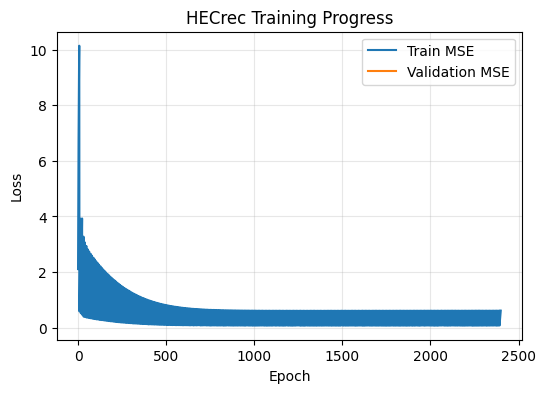

In [33]:
from HERec import HECrec
# Load train/test splits
R_train = np.load("data/ratings_train.npy")
R_test = np.load("data/ratings_test.npy")

print(f"Train shape: {R_train.shape}, Test shape: {R_test.shape}")
# Example: use UMU for users; MGM and MYM for items
user_embeds_list = [model_UMU,model_UMYMU,model_UMGMU]                      # list of dicts
item_embeds_list = [model_MGM, model_MYM,model_MGMYM]           # list of dicts
user_ids = sorted(model_UMU.keys(), key=lambda x: int(x[1:]))
item_ids = sorted(model_MGM.keys(), key=lambda x: int(x[1:]))

model = HECrec(
    user_embeds_list=user_embeds_list,
    item_embeds_list=item_embeds_list,
    user_ids=user_ids,
    item_ids=item_ids,
    D_mf=10,D_emb = 64, alpha=5.0, beta=5.0
)

model.fit(R_train, lr=0.001, epochs=300, batch_size=4096, verbose=True)
R_pred = model.predict()


In [34]:
#KeyError: 'M3674'
# Evaluate only on test entries that are not NaN
mask_test = ~np.isnan(R_test)
true_values = R_test[mask_test]
pred_values = R_pred[mask_test]


# Compute RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.9066


In [54]:
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from math import sqrt


def user_based_split(R, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    R_train = np.full_like(R, np.nan)
    R_test = np.full_like(R, np.nan)

    for u in range(R.shape[0]):
        items = np.where(~np.isnan(R[u]))[0]
        if len(items) == 0:
            continue
        test_size = max(1, int(len(items) * test_ratio))
        test_items = np.random.choice(items, size=test_size, replace=False)
        train_items = np.setdiff1d(items, test_items)
        R_train[u, train_items] = R[u, train_items]
        R_test[u, test_items] = R[u, test_items]

    return R_train, R_test



def compute_rmse(R_true, R_pred):
    mask = ~np.isnan(R_true)
    return sqrt(mean_squared_error(R_true[mask], R_pred[mask]))



def random_search_hyperparams(R, user_embeds_list, item_embeds_list,
                              user_ids, item_ids, n_trials=10,
                              alpha_range=(0.5, 10.0),
                              beta_range=(0.5, 10.0),
                              Dmf_choices=(8, 16, 32),
                              lr=0.001, epochs=100, batch_size=2048,
                              test_ratio=0.2):
    results = []

    for trial in range(n_trials):
        alpha = round(random.uniform(*alpha_range), 2)
        beta = round(random.uniform(*beta_range), 2)
        D_mf = random.choice(Dmf_choices)

        print(f"\n Trial {trial+1}/{n_trials} | alpha={alpha}, beta={beta}, D_mf={D_mf}")

        # Split dataset per trial to ensure independence
        R_train, R_test = user_based_split(R, test_ratio=test_ratio, seed=trial)

        model = HECrec(
            user_embeds_list=user_embeds_list,
            item_embeds_list=item_embeds_list,
            user_ids=user_ids,
            item_ids=item_ids,
            D_mf=D_mf, D_emb=64, alpha=alpha, beta=beta
        )

        model.fit(R_train, lr=lr, epochs=epochs, batch_size=batch_size, verbose=False)
        R_pred = model.predict()
        rmse = compute_rmse(R_test, R_pred)

        print(f"   → RMSE = {rmse:.4f}")
        results.append((alpha, beta, D_mf, rmse))

    # Find best config
    best = min(results, key=lambda x: x[3])
    print("\nBest configuration:")
    print(f"   alpha={best[0]}, beta={best[1]}, D_mf={best[2]}, RMSE={best[3]:.4f}")

    return best, results


# ----------------------------
#  Run the random search
# ----------------------------
best_params, all_results = random_search_hyperparams(
    R=R_combined,                   # or full dataset R if you want resplitting each trial
    user_embeds_list = [model_UMU,model_UMYMU,model_UMGMU],           # list of dicts
    item_embeds_list = [model_MGM, model_MYM],
    user_ids=sorted(model_UMU.keys(), key=lambda x: int(x[1:])),
    item_ids=sorted(model_MGM.keys(), key=lambda x: int(x[1:])),
    n_trials=30,                  # increase for more thorough search
    alpha_range=(0.65, 1.0),
    beta_range=(1.2 ,1.5),
    Dmf_choices=[10,12,13,15],
    lr=0.001,
    epochs=80,                   # shorter for tuning, can increase later
    batch_size=4096,
    test_ratio=0.2
)

# Best configuration:
#    alpha=1.21, beta=5.11, D_mf=7, RMSE=0.8573



 Trial 1/30 | alpha=0.87, beta=1.23, D_mf=13
   → RMSE = 0.8672

 Trial 2/30 | alpha=0.94, beta=1.39, D_mf=10
   → RMSE = 0.8711

 Trial 3/30 | alpha=0.73, beta=1.23, D_mf=15
   → RMSE = 0.8731

 Trial 4/30 | alpha=0.93, beta=1.34, D_mf=12
   → RMSE = 0.8710

 Trial 5/30 | alpha=0.97, beta=1.4, D_mf=10
   → RMSE = 0.8573

 Trial 6/30 | alpha=0.75, beta=1.24, D_mf=13
   → RMSE = 0.8748

 Trial 7/30 | alpha=0.94, beta=1.43, D_mf=15
   → RMSE = 0.8542

 Trial 8/30 | alpha=0.74, beta=1.42, D_mf=12
   → RMSE = 0.8605

 Trial 9/30 | alpha=0.8, beta=1.31, D_mf=10
   → RMSE = 0.8750

 Trial 10/30 | alpha=0.82, beta=1.37, D_mf=12
   → RMSE = 0.8816

 Trial 11/30 | alpha=0.71, beta=1.48, D_mf=13
   → RMSE = 0.8592

 Trial 12/30 | alpha=0.86, beta=1.41, D_mf=12
   → RMSE = 0.8708

 Trial 13/30 | alpha=0.7, beta=1.39, D_mf=15
   → RMSE = 0.8682

 Trial 14/30 | alpha=0.93, beta=1.24, D_mf=13
   → RMSE = 0.8806

 Trial 15/30 | alpha=0.96, beta=1.37, D_mf=13
   → RMSE = 0.8670

 Trial 16/30 | alpha=

In [49]:
all_results

[(0.97, 0.95, 16, 0.8828682815194326),
 (0.73, 1.17, 14, 0.877461330891854),
 (1.03, 1.37, 10, 0.8681800731904324),
 (1.01, 1.24, 14, 0.8745561142170728),
 (0.76, 1.35, 14, 0.8597178966193755),
 (0.98, 1.33, 20, 0.8730111105155504),
 (0.83, 0.98, 10, 0.8719030754747834),
 (1.17, 1.48, 20, 0.8601311307143485),
 (0.79, 1.42, 20, 0.8729569702309674),
 (1.06, 1.15, 14, 0.887708148894616),
 (0.84, 0.94, 16, 0.8843968474763311),
 (0.88, 1.42, 16, 0.8708224509685917),
 (1.1, 1.24, 20, 0.8726940381131605),
 (1.06, 1.13, 14, 0.885787751666261),
 (1.02, 1.23, 20, 0.8699576718754859),
 (0.82, 1.25, 14, 0.8747090164720734),
 (0.75, 0.71, 16, 0.9099280990038754),
 (0.89, 1.31, 10, 0.8683601140875634),
 (1.04, 1.3, 20, 0.8656268764952099),
 (0.96, 1.27, 20, 0.8750390899240486)]

In [13]:
import numpy as np
import pandas as pd
import torch
from math import sqrt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

def user_based_split(R, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    R_train = np.full_like(R, np.nan)
    R_test = np.full_like(R, np.nan)
    for u in range(R.shape[0]):
        items = np.where(~np.isnan(R[u]))[0]
        if len(items) == 0:
            continue
        test_size = max(1, int(len(items) * test_ratio))
        test_items = np.random.choice(items, size=test_size, replace=False)
        train_items = np.setdiff1d(items, test_items)
        R_train[u, train_items] = R[u, train_items]
        R_test[u, test_items] = R[u, test_items]
    return R_train, R_test

def compute_rmse(R_true, R_pred):
    mask = ~np.isnan(R_true)
    return sqrt(mean_squared_error(R_true[mask], R_pred[mask]))

def grid_search_hecrec(
    R,
    user_embeds_list,
    item_embeds_list,
    user_ids,
    item_ids,
    alphas=[0.1, 0.5, 1, 2, 5],
    betas=[0.1, 0.5, 1, 2, 5],
    Dmf_values=[5, 10, 20, 40],
    lr=0.001,
    epochs=60,
    batch_size=2048,
    test_ratio=0.2,
    results_dir="results_gridsearch"
):
    import os
    os.makedirs(results_dir, exist_ok=True)

    R_train, R_test = user_based_split(R, test_ratio=test_ratio, seed=42)

    results = []
    for D_mf in Dmf_values:
        for alpha in alphas:
            for beta in betas:
                model = HECrec(
                    user_embeds_list=user_embeds_list,
                    item_embeds_list=item_embeds_list,
                    user_ids=user_ids,
                    item_ids=item_ids,
                    D_mf=D_mf,
                    D_emb=64,
                    alpha=alpha,
                    beta=beta,
                )

                model.fit(R_train, lr=lr, epochs=epochs, batch_size=batch_size, verbose=False)
                R_pred = model.predict()
                rmse = compute_rmse(R_test, R_pred)
                results.append(dict(alpha=alpha, beta=beta, D_mf=D_mf, RMSE=rmse))
                print(f"α={alpha:>4}, β={beta:>4}, D_mf={D_mf:>3} → RMSE={rmse:.4f}")

    df = pd.DataFrame(results)
    csv_path = os.path.join(results_dir, "hecrec_gridsearch_results.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Results saved to {csv_path}")
    return df


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_alpha_beta_surface(df, D_mf_target):
    """3D surface plot of RMSE vs α, β for a given D_mf."""
    df_sub = df[df["D_mf"] == D_mf_target]
    A = sorted(df_sub["alpha"].unique())
    B = sorted(df_sub["beta"].unique())
    Z = np.zeros((len(A), len(B)))

    for i, a in enumerate(A):
        for j, b in enumerate(B):
            Z[i, j] = df_sub[(df_sub["alpha"] == a) & (df_sub["beta"] == b)]["RMSE"].values[0]

    A, B = np.meshgrid(A, B)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(A, B, Z.T, cmap="viridis", alpha=0.9, edgecolor="none")
    ax.set_xlabel("α")
    ax.set_ylabel("β")
    ax.set_zlabel("RMSE")
    ax.set_title(f"RMSE surface (D_mf={D_mf_target})")
    plt.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

def plot_iterations_vs_rmse(iter_losses):
    """Plot RMSE vs number of iterations."""
    plt.figure(figsize=(5,3))
    plt.plot(range(1, len(iter_losses)+1), iter_losses, marker="*")
    plt.xlabel("Number of Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE vs Iterations")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_dmf_vs_rmse(df):
    """Plot RMSE vs latent dimension D_mf."""
    avg = df.groupby("D_mf")["RMSE"].mean().reset_index()
    plt.figure(figsize=(5,3))
    plt.plot(avg["D_mf"], avg["RMSE"], marker="*")
    plt.xlabel("Dimension of Latent Factors (D_mf)")
    plt.ylabel("RMSE")
    plt.title("Effect of Latent Factor Dimension")
    plt.grid(True, alpha=0.3)
    plt.show()


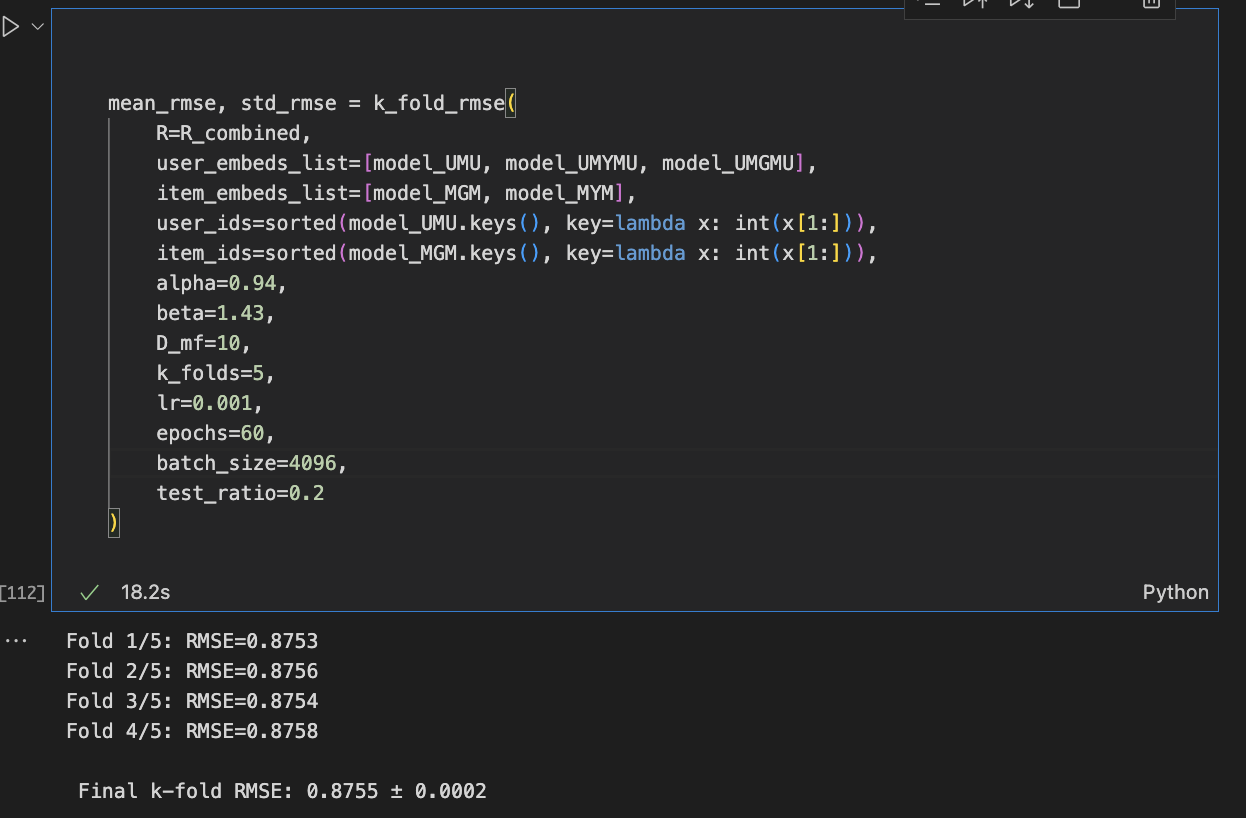

α= 0.1, β= 0.1, D_mf=  5 → RMSE=1.7660
α= 0.1, β= 0.5, D_mf=  5 → RMSE=1.0093
α= 0.1, β=   1, D_mf=  5 → RMSE=0.9086
α= 0.1, β= 1.5, D_mf=  5 → RMSE=0.8980
α= 0.1, β=   5, D_mf=  5 → RMSE=0.9046
α= 0.5, β= 0.1, D_mf=  5 → RMSE=1.4506
α= 0.5, β= 0.5, D_mf=  5 → RMSE=1.0045
α= 0.5, β=   1, D_mf=  5 → RMSE=0.8962
α= 0.5, β= 1.5, D_mf=  5 → RMSE=0.8826
α= 0.5, β=   5, D_mf=  5 → RMSE=0.8883
α=   1, β= 0.1, D_mf=  5 → RMSE=1.1522
α=   1, β= 0.5, D_mf=  5 → RMSE=0.9836
α=   1, β=   1, D_mf=  5 → RMSE=0.8909
α=   1, β= 1.5, D_mf=  5 → RMSE=0.8752
α=   1, β=   5, D_mf=  5 → RMSE=0.8764
α=   5, β= 0.1, D_mf=  5 → RMSE=0.9551
α=   5, β= 0.5, D_mf=  5 → RMSE=0.9330
α=   5, β=   1, D_mf=  5 → RMSE=0.9214
α=   5, β= 1.5, D_mf=  5 → RMSE=0.9105
α=   5, β=   5, D_mf=  5 → RMSE=0.9033
α= 0.1, β= 0.1, D_mf= 10 → RMSE=1.7438
α= 0.1, β= 0.5, D_mf= 10 → RMSE=1.0092
α= 0.1, β=   1, D_mf= 10 → RMSE=0.9084
α= 0.1, β= 1.5, D_mf= 10 → RMSE=0.8981
α= 0.1, β=   5, D_mf= 10 → RMSE=0.9041
α= 0.5, β= 0.1, D_mf= 10 

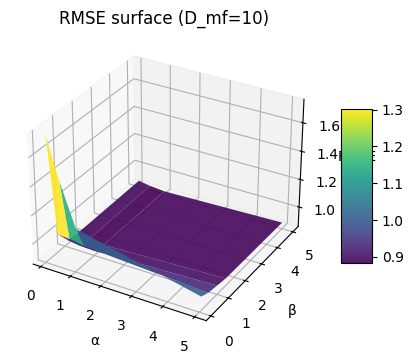

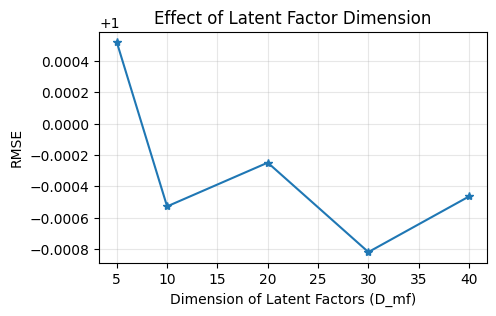

In [113]:
# === Run the grid search ===
df_results = grid_search_hecrec(
    R=R_combined,
    user_embeds_list=[model_UMU],
    item_embeds_list=[model_MGM, model_MYM],
    user_ids=user_ids,
    item_ids=item_ids,
    alphas=[ 0.1,0.5,1,5],
    betas=[0.1,0.5,1,1.5,5],
    Dmf_values=[5,10,20,30,40],
    epochs=60
)

# === Plot 3D surface for one D_mf ===
plot_alpha_beta_surface(df_results, D_mf_target=10)

# === Plot RMSE vs iterations (you can record RMSE each epoch in fit) ===
# plot_iterations_vs_rmse(train_rmse_per_epoch)

# === Plot RMSE vs D_mf ===
plot_dmf_vs_rmse(df_results)


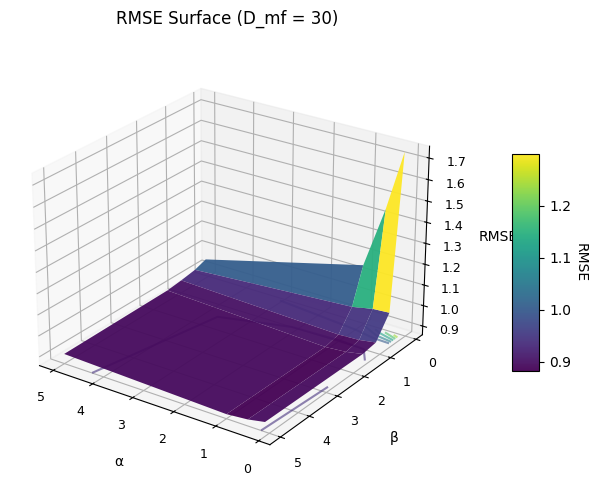

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_alpha_beta_surface_2(df, D_mf_target):
    df_sub = df[df["D_mf"] == D_mf_target]
    A = sorted(df_sub["alpha"].unique())
    B = sorted(df_sub["beta"].unique())

    # Create grid and fill with RMSE values
    Z = np.zeros((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            val = df_sub[(df_sub["alpha"] == a) & (df_sub["beta"] == b)]["RMSE"].values
            Z[i, j] = val[0] if len(val) > 0 else np.nan

    A, B = np.meshgrid(A, B)

    # --- Aesthetic improvements ---
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=25, azim=125)  # better angle
    surf = ax.plot_surface(
        A, B, Z.T,
        cmap="viridis",
        linewidth=0.3,
        antialiased=True,
        alpha=0.95,
        rstride=1,
        cstride=1,
        edgecolor="none",
        shade=True
    )

    # Optional contour projections
    ax.contour(A, B, Z.T, zdir='z', offset=np.nanmin(Z)*0.98, cmap='viridis', alpha=0.6)

    # Labels & formatting
    ax.set_xlabel("α", labelpad=10)
    ax.set_ylabel("β", labelpad=10)
    ax.set_zlabel("RMSE", labelpad=10)
    ax.set_title(f"RMSE Surface (D_mf = {D_mf_target})", pad=15)

    # Set consistent tick spacing
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    ax.zaxis.set_tick_params(labelsize=9)

    # Add colorbar
    cbar = fig.colorbar(surf, shrink=0.5, aspect=8, pad=0.1)
    cbar.set_label("RMSE", rotation=270, labelpad=12)

    plt.tight_layout()
    plt.show()
plot_alpha_beta_surface_2(df_results,30)

In [119]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_alpha_beta_surface_paper(df, D_mf_target):
    df_sub = df[df["D_mf"] == D_mf_target]
    A = sorted(df_sub["alpha"].unique())
    B = sorted(df_sub["beta"].unique())

    Z = np.zeros((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            val = df_sub[(df_sub["alpha"] == a) & (df_sub["beta"] == b)]["RMSE"].values
            Z[i, j] = val[0] if len(val) > 0 else np.nan

    A, B = np.meshgrid(A, B)

    # Find the minimum RMSE point
    min_idx = np.nanargmin(Z)
    i_min, j_min = np.unravel_index(min_idx, Z.shape)
    a_min, b_min, rmse_min = A[i_min, j_min], B[i_min, j_min], Z[i_min, j_min]

    # --- Create the figure ---
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111, projection="3d")

    # --- Wireframe style (no shading, no fill, thin lines) ---
    ax.plot_wireframe(
        A, B, Z.T,
        color="black",
        linewidth=0.7,
        rstride=1,
        cstride=1
    )

    # Overlay colored surface (transparent, light gradient)
    surf = ax.plot_surface(
        A, B, Z.T,
        cmap="viridis",
        alpha=0.65,
        linewidth=0,
        antialiased=True
    )

    # Red dot for the minimum point
    ax.scatter(1, 1.5, rmse_min, color="red", s=50, depthshade=True)

    # --- Aesthetic details ---
    ax.view_init(elev=20, azim=135)
    ax.set_xlabel("α", labelpad=8)
    ax.set_ylabel("β", labelpad=8)
    ax.set_zlabel("RMSE", labelpad=8)
    ax.set_title(f"RMSE surface (D_mf={D_mf_target})", pad=10)

    # Remove panes & make grid subtle
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo["grid"]['linewidth'] = 0.3
    ax.yaxis._axinfo["grid"]['linewidth'] = 0.3
    ax.zaxis._axinfo["grid"]['linewidth'] = 0.3

    # --- Colorbar ---
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.1)
    cbar.set_label("RMSE", rotation=270, labelpad=12)

    plt.tight_layout()
    plt.show()

    print(f"Best (α, β) = ({a_min}, {b_min}) with RMSE = {rmse_min:.4f}")


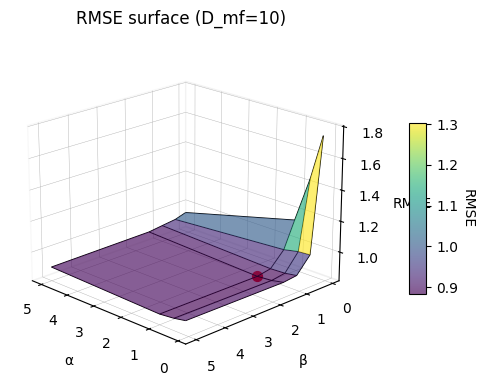

Best (α, β) = (5.0, 1.0) with RMSE = 0.8757


In [120]:
plot_alpha_beta_surface_paper(df_results, D_mf_target=10)


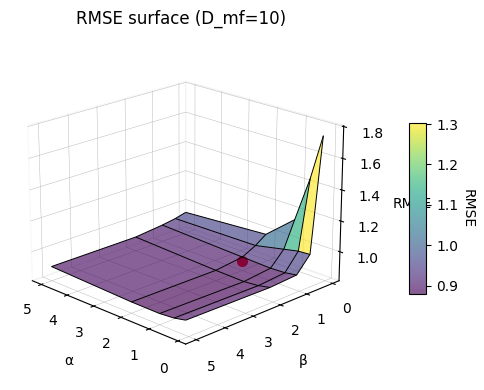

## Final model rmse

In [60]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

def compute_rmse(R_true, R_pred):
    mask = ~np.isnan(R_true)
    return sqrt(mean_squared_error(R_true[mask], R_pred[mask]))

def k_fold_rmse(
    R,
    user_embeds_list,
    item_embeds_list,
    user_ids,
    item_ids,
    alpha,
    beta,
    D_mf,
    k_folds=5,
    lr=0.001,
    epochs=80,
    batch_size=4096,
    seed=42,
    test_ratio= 0.2
):
    """
    Estimate final RMSE with k-fold cross-validation on users.
    Each fold holds out a disjoint set of users as test data.
    """
    
    fold_rmses = []
    for k in range(1,k_folds):
        # --- Split ---
        R_train, R_test = user_based_split(R, test_ratio=test_ratio, seed=42)

        

        # --- Train model on train users ---
        model = HECrec(
            user_embeds_list=user_embeds_list,
            item_embeds_list=item_embeds_list,
            user_ids=user_ids,
            item_ids=item_ids,
            D_mf=D_mf,
            D_emb = 64,
            alpha=alpha,
            beta=beta,
        )

        model.fit(R_train, lr=lr, epochs=epochs, batch_size=batch_size, verbose=False)

        # --- Predict and compute RMSE on test users ---
        R_pred = model.predict()
        rmse = compute_rmse(R_test, R_pred)
        fold_rmses.append(rmse)
        print(f"Fold {k}/{k_folds}: RMSE={rmse:.4f}")

    mean_rmse = np.mean(fold_rmses)
    std_rmse = np.std(fold_rmses)
    print(f"\n Final k-fold RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
    return mean_rmse, std_rmse


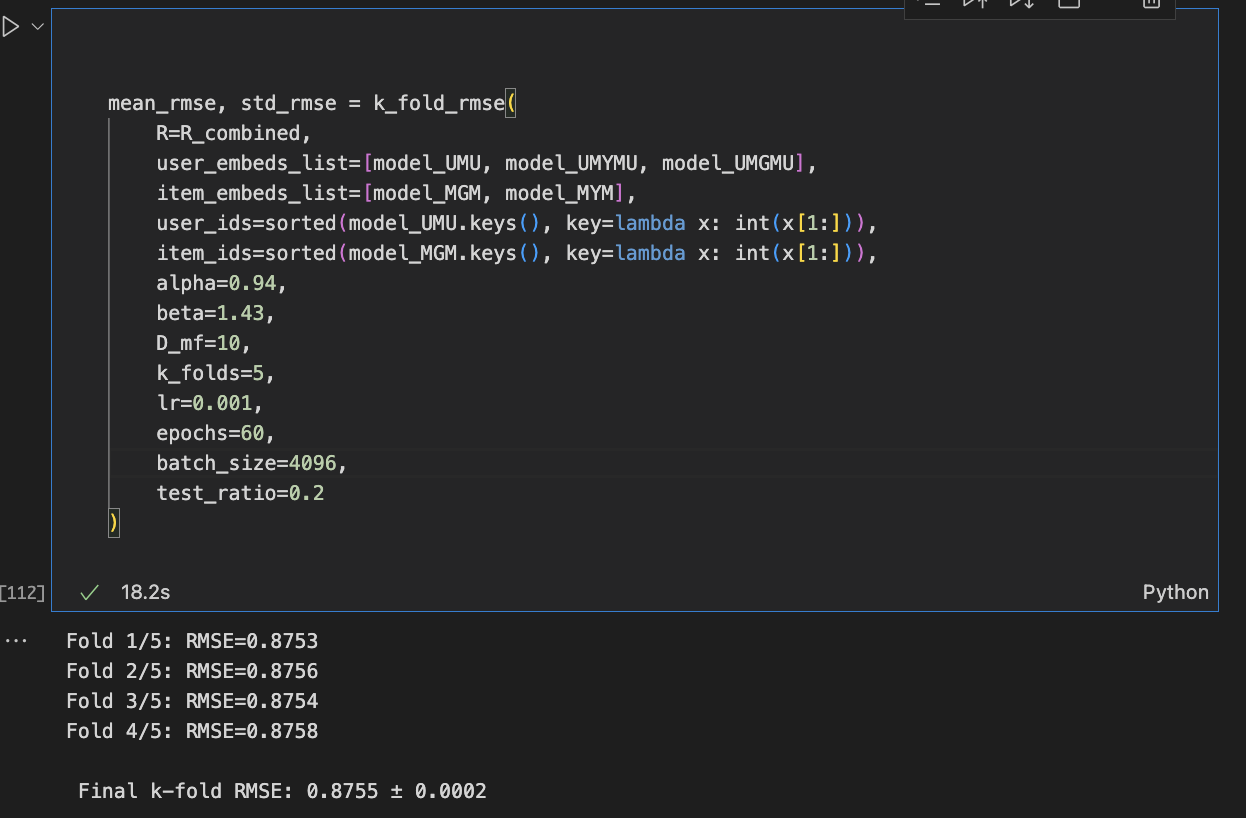

In [121]:


mean_rmse, std_rmse = k_fold_rmse(
    R=R_combined,
    user_embeds_list=[model_UMU, model_UMYMU, model_UMGMU],
    item_embeds_list=[model_MGM, model_MYM],
    user_ids=sorted(model_UMU.keys(), key=lambda x: int(x[1:])),
    item_ids=sorted(model_MGM.keys(), key=lambda x: int(x[1:])),
    alpha=1,
    beta=1.5,
    D_mf=10,
    k_folds=5,
    lr=0.001,
    epochs=60,
    batch_size=4096,
    test_ratio=0.2
)


Fold 1/5: RMSE=0.8741
Fold 2/5: RMSE=0.8739
Fold 3/5: RMSE=0.8739
Fold 4/5: RMSE=0.8741

 Final k-fold RMSE: 0.8740 ± 0.0001
